In [1]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!unzip dogImages.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!unzip lfw.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("C:/Users/Gidama1/Downloads/lfw/*/*"))
dog_files = np.array(glob("C:/Users/Gidama1/Downloads/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [2]:
# NOTICE: If you run locally, the file `haarcascade_frontalface_alt.xml` is ready to use 
# in the start code. You DO NOT need to run the following command to re-download it again!

# Download haarcascade_frontalface_alt.xml
#!mkdir haarcascades
#!wget -P haarcascades/ https://www.dropbox.com/s/dy70c8t97775y6i/haarcascade_frontalface_alt.xml

Number of faces detected: 1


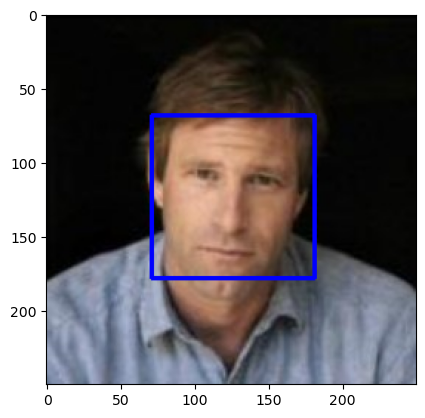

In [3]:
!pip install opencv-python
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('C:/Users/Gidama1/Downloads/Project_2_Dog_Recognition(Part_B_Start_Code) (1)/Project_2_Dog_Recognition(Part_B_Start_Code)/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Use the code cell below to test the performance of the `face_detector` function. Then, you will see the results based on OpenCV detector
- The percentage of the first 100 images in `human_files` having a detected human face.
- The percentage of the first 100 images in `dog_files` having a detected human face. 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_in_human_imgs = 0
human_in_dog_imgs = 0

for human in human_files_short:
    if face_detector(human):
        human_in_human_imgs +=1

for dog in dog_files_short:
    if face_detector(dog):
        human_in_dog_imgs +=1
    
print('%d%% of human images detected a face.' % human_in_human_imgs)
print('%d%% of dog images detected a face.' % human_in_dog_imgs)


96% of human images detected a face.
18% of dog images detected a face.


Here, we use the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :). 

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
!pip install torch
!pip install --upgrade torch
!pip install torchvision
import torch
import torchvision.models as models


# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

C:\Users\Gidama1\AppData\Local\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Gidama1\AppData\Local\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Gidama1/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.3MB/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, you will see a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

You could take the time to learn how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image, ImageFile
import torchvision.transforms as transforms

ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image

    # All pre-trained models expect input images normalized in the same way, 
    # i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
    # where H and W are expected to be at least 224. 
    # The images have to be loaded in to a range of [0, 1] 
    # and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor(), 
                                    normalize])
    
    # Open image and apply transformation
    image = Image.open(img_path)
    image = transform(image)
    image.unsqueeze_(0)
    
    # move image to GPU if CUDA is available
    if use_cuda:
        image = image.cuda()

    # Predict using VGG16
    image_var = torch.autograd.Variable(image)
    prediction = VGG16(image_var)
    value, index = torch.max(prediction, 1)

    return index[0].item() # predicted class index

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction_index = VGG16_predict(img_path)
    return (151 <= prediction_index <= 268) # true/false

### Assess the Dog Detector use a Pre-trained CNN

Use the code cell below to test the performance of your `dog_detector` function. It will indicate:  
- The percentage of the images in `human_files_short` having a detected dog.  
- The percentage of the images in `dog_files_short` having a detected dog.

In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_in_human_imgs = 0
dog_in_dog_imgs = 0

for human in human_files_short:
    if dog_detector(human):
        dog_in_human_imgs +=1

for dog in dog_files_short:
    if dog_detector(dog):
        dog_in_dog_imgs +=1
    
print('%d%% of human images detected as a dog.' % dog_in_human_imgs)
print('%d%% of dog images detected as a dog.' % dog_in_dog_imgs)

0% of human images detected as a dog.
94% of dog images detected as a dog.


As you can see, the detection result is perfect by using pre-trained CNNs. We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc). 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least **10%**.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://www.dropbox.com/s/bo3mwqju253alon/Brittany_02625.jpg?dl=1" width="100"> | <img src="https://www.dropbox.com/s/lb2hzvq2m5y44rg/Welsh_springer_spaniel_08203.jpg?dl=1" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://www.dropbox.com/s/p65g938k8q0kfbf/Curly-coated_retriever_03896.jpg?dl=1" width="200"> | <img src="https://www.dropbox.com/s/b9zv9v6iv16f4l1/American_water_spaniel_00648.jpg?dl=1" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | - | -
<img src="https://www.dropbox.com/s/nni1x0fvxu8apqu/Labrador_retriever_06457.jpg?dl=1" width="150"> | <img src="https://www.dropbox.com/s/7ik3skchbd89yas/Labrador_retriever_06455.jpg?dl=1" width="240"> | <img src="https://www.dropbox.com/s/64fboclmef83zd1/Labrador_retriever_06449.jpg?dl=1" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

In [10]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# define dataloader parameters
batch_size = 32

# Tranformation with data augmentation to be used on the training set
train_transform = transforms.Compose([
                                transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
])

# Tranformation with data augmentation to be used on the validation and test set
test_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
])

# Defining the datasets for training, validation and testing
train_data = datasets.ImageFolder('dogImages/train', transform=train_transform)
valid_data = datasets.ImageFolder('dogImages/valid', transform=test_transform)
test_data = datasets.ImageFolder('dogImages/test', transform=test_transform)

# Defining the loaders for training, validation and testing
loaders_scratch={
    'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
}

### Model Architecture

Create a CNN to classify dog breed.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # implementing the Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # implementing the Dropout layer
        self.dropout = nn.Dropout(0.25)
        
        # implementing the Linear layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 133)  # 133 classes for dog breed classification
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))  # output size: (32, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # output size: (64, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))  # output size: (128, 28, 28)
        
        x = x.view(-1, 128 * 28 * 28)  # flatten the tensor
        
        x = self.dropout(x)  # apply dropout
        
        x = F.relu(self.fc1(x))  # apply linear layer
        x = self.dropout(x)  # apply dropout
        x = self.fc2(x)  # apply final linear layer
        
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
)


###  Specify Loss Function and Optimizer

In [12]:
import torch.optim as optim


# Using the cross-entopy loss function as our loss function
criterion_scratch = nn.CrossEntropyLoss()


# Using the stochastic gradient descent for our optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### Train and Validate the Model


In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## TODO: 
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## TODO: 
            ## update the average validation loss
            ## record the average validation loss, using something like
            ## valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    

    # return trained model
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.883726 	Validation Loss: 4.855400
Validation loss decreased (inf --> 4.855400).  Saving model ...
Epoch: 2 	Training Loss: 4.841969 	Validation Loss: 4.775073
Validation loss decreased (4.855400 --> 4.775073).  Saving model ...
Epoch: 3 	Training Loss: 4.775293 	Validation Loss: 4.650216
Validation loss decreased (4.775073 --> 4.650216).  Saving model ...
Epoch: 4 	Training Loss: 4.680728 	Validation Loss: 4.547043
Validation loss decreased (4.650216 --> 4.547043).  Saving model ...
Epoch: 5 	Training Loss: 4.621508 	Validation Loss: 4.489695
Validation loss decreased (4.547043 --> 4.489695).  Saving model ...
Epoch: 6 	Training Loss: 4.582895 	Validation Loss: 4.449390
Validation loss decreased (4.489695 --> 4.449390).  Saving model ...
Epoch: 7 	Training Loss: 4.555919 	Validation Loss: 4.409320
Validation loss decreased (4.449390 --> 4.409320).  Saving model ...
Epoch: 8 	Training Loss: 4.530247 	Validation Loss: 4.352682
Validation loss decreased (4.40932

<All keys matched successfully>

### Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater equal than 10%.

In [14]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.493860


Test Accuracy: 20% (169/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)


### Specify Data Loaders for the Dog Dataset

In [15]:
## Specify data loaders (we use the same data loader created in step 3)
loaders_transfer = loaders_scratch.copy()

### Model Architecture

In [30]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture
# Using the pretrained Resnet50 model
model_transfer = models.resnet50(pretrained=True)

# Freeze training for all "features" layers
for x in model_transfer.parameters():
    x.requires_grad = False
# replace the last fully connected layer with a Linnear layer 133 output
nn_inputs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(nn_inputs, 133)

if use_cuda:
    model_transfer = model_transfer.cuda()
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###  Specify Loss Function and Optimizer

In [31]:
#Using the cross entropy loss function as the loss function and stochastic gradient as the optimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION [5 points]) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [32]:
# train the model
model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.863918 	Validation Loss: 4.742794
Validation loss decreased (inf --> 4.742794).  Saving model ...
Epoch: 2 	Training Loss: 4.715257 	Validation Loss: 4.574458
Validation loss decreased (4.742794 --> 4.574458).  Saving model ...
Epoch: 3 	Training Loss: 4.591067 	Validation Loss: 4.429911
Validation loss decreased (4.574458 --> 4.429911).  Saving model ...
Epoch: 4 	Training Loss: 4.467334 	Validation Loss: 4.274100
Validation loss decreased (4.429911 --> 4.274100).  Saving model ...
Epoch: 5 	Training Loss: 4.353447 	Validation Loss: 4.143039
Validation loss decreased (4.274100 --> 4.143039).  Saving model ...
Epoch: 6 	Training Loss: 4.239743 	Validation Loss: 3.967888
Validation loss decreased (4.143039 --> 3.967888).  Saving model ...
Epoch: 7 	Training Loss: 4.133552 	Validation Loss: 3.865193
Validation loss decreased (3.967888 --> 3.865193).  Saving model ...
Epoch: 8 	Training Loss: 4.026892 	Validation Loss: 3.724473
Validation loss decreased (3.86519

<All keys matched successfully>

### Test the Model

In [34]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.495672


Test Accuracy: 66% (559/836)


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [37]:
### The function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    # All pre-trained models expect input images normalized in the same way, 
    # i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
    # where H and W are expected to be at least 224. 
    # The images have to be loaded in to a range of [0, 1] 
    # and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor(), 
                                    normalize])
    
    # Open image and apply transformation
    image = Image.open(img_path)
    image = transform(image)
    image.unsqueeze_(0)
    
    # move image to GPU if CUDA is available
    if use_cuda:
        image = image.cuda()

    # Predict using model_transfer
    image_var = torch.autograd.Variable(image)
    prediction = model_transfer(image_var)
    value, index = torch.max(prediction, 1)

    return class_names[index[0].item()]

---
<a id='step5'></a>
## Step 5: Single Image Prediction

An algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.



![Sample Human Output](https://www.dropbox.com/s/53a4v25xecb4iz1/sample_human_output.png?dl=1)


### A Fuction Called `run_app` Being Ready for Single Image Prediction

In [38]:
### Write your algorithm.
### Feel free to use as many code cells as needed.
from PIL import Image
import requests
from io import BytesIO

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    
    if dog_detector(img_path):
        plt.imshow(img)
        plt.show()
        print('Hello, dog!')
        print('Your predicted breed is ...', predict_breed_transfer(img_path))
    elif face_detector(img_path):
        plt.imshow(img)
        plt.show()
        print('Hello, human!')
        print('Your look like a ...', predict_breed_transfer(img_path))
    else:
        plt.imshow(img)
        plt.show()
        print('Classification error, no dog or human found!')

---
<a id='step6'></a>
## Step 6: Test Your Model

In this section, you will take your new model for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Model on Sample Images!  

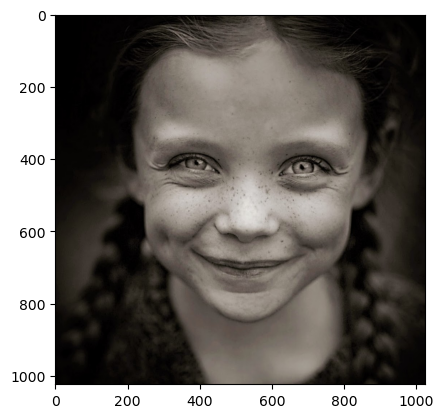

Hello, human!
Your look like a ... Bull terrier


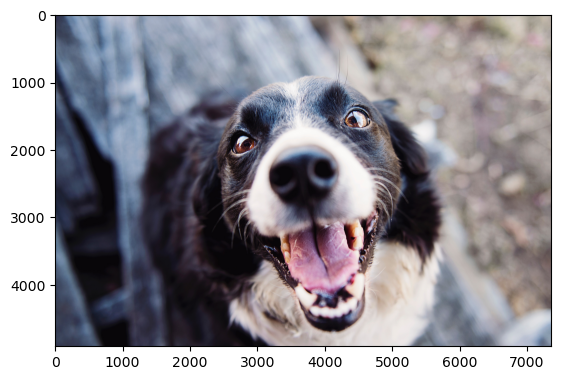

Hello, dog!
Your predicted breed is ... Border collie


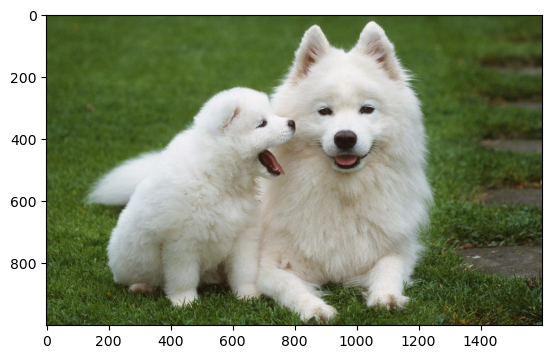

Hello, dog!
Your predicted breed is ... American eskimo dog


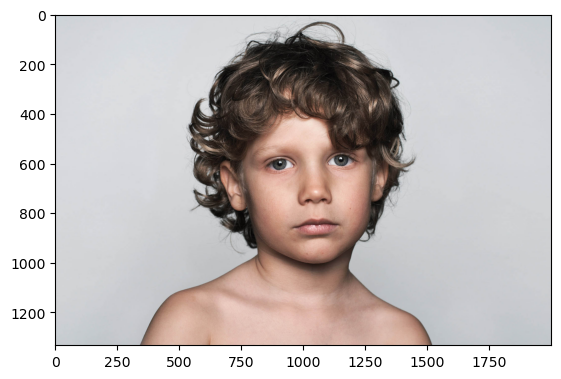

Hello, human!
Your look like a ... Affenpinscher


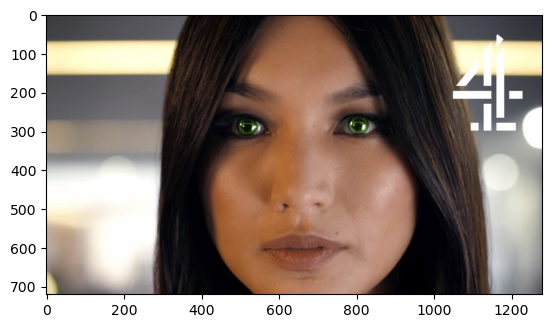

Hello, human!
Your look like a ... Basenji


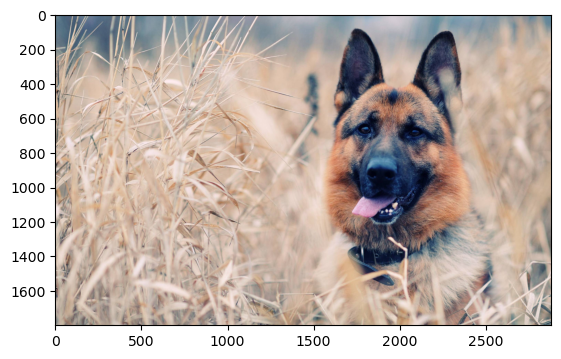

Hello, dog!
Your predicted breed is ... Belgian malinois


In [39]:
for filename in os.listdir('./test_images/'):
    if filename.endswith(".jpg"):
        run_app('./test_images/' + filename)    